In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from sklearn.metrics.pairwise import cosine_distances
from sklearn.manifold import TSNE
from sklearn.cluster import FeatureAgglomeration
from scipy.interpolate import griddata
from scipy.spatial.distance import pdist, cosine
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering, dendrogram, leaves_list
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
import seaborn as sns
import openTSNE

original = "baseline"
channels = ["DNA", "RNA", "AGP", "ER", "Mito"]
colors = ['#808080', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

f_cols = list(map(str, range(672)))

baseline_features = pd.read_csv(f"features/{original}_wells.csv")[f_cols]
channel_features = {ch: pd.read_csv(f"features/{ch}_wells.csv")[f_cols] for ch in channels}

# Info

- Vsi razen posamezen kanal so povprečeni z ```mean``` sliko (Vsi pixli imajo enako vrednost - mean vseh pikslov slik kanala v datasetu).

## t-SNE - t-distributed Stochastic Neighbor Embedding
- Nonlinear dimensionality reduction

```perplexity```: number of nearest neighbors for each point

```early_exaggeration```: control tightness with which t-SNE will try to keep points together in the map space, higher value results in clusters more tightly drawn together

```n_iter```: number of iterations for optimization

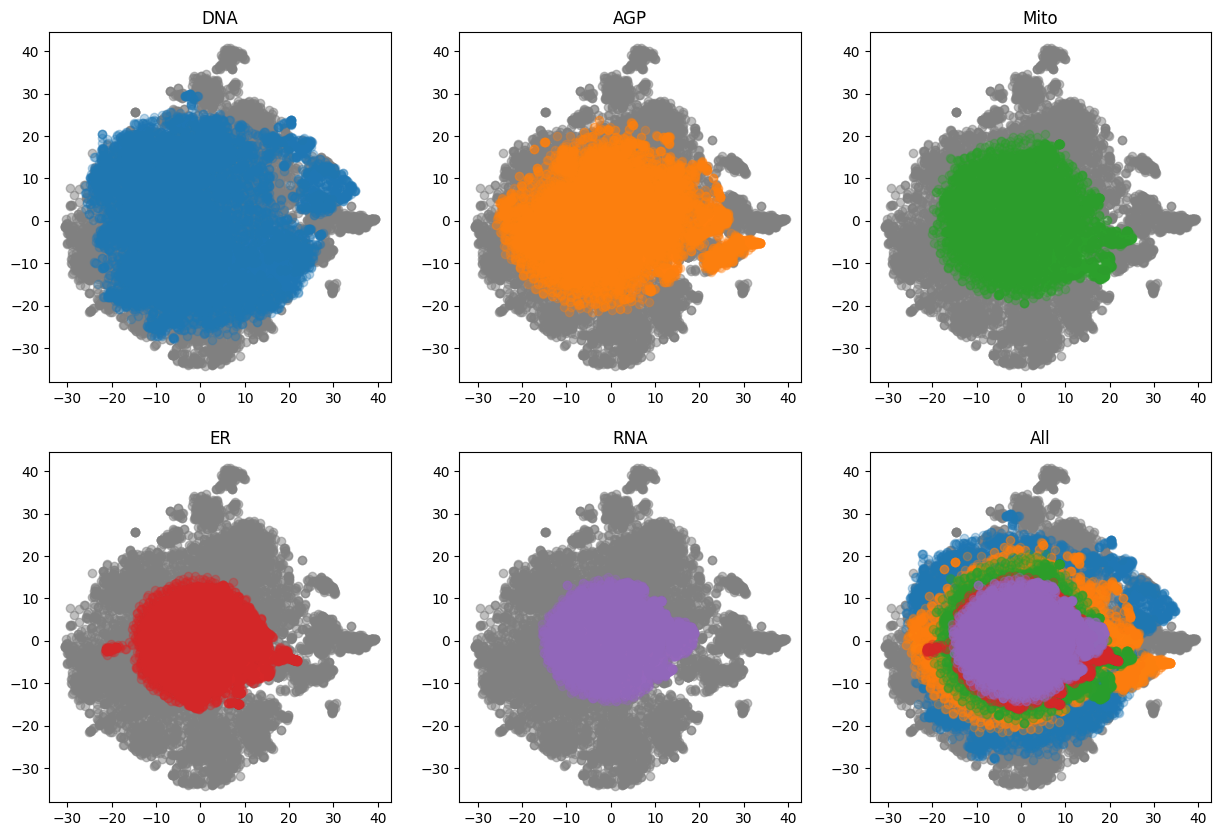

In [30]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=500, early_exaggeration=6)
bt = tsne.fit_transform(baseline_features)

chnls = ["DNA", "AGP", "Mito", "ER", "RNA"]
fig, ax = plt.subplots(2,3, figsize=(15,10))

for i, ch in enumerate(chnls):
    t = tsne.fit_transform(channel_features[ch])
    
    if i == 0:
        ax.flatten()[-1].scatter(bt[:,0], bt[:,1], alpha=0.5, label='Original', color=colors[0])
        ax.flatten()[-1].set_title("All")

    ax.flatten()[i].scatter(bt[:,0], bt[:,1], alpha=0.5, label='Original', color=colors[0])
    ax.flatten()[i].scatter(t[:,0], t[:,1], alpha=0.3, label=ch, color=colors[i + 1])
    ax.flatten()[i].set_title(str(ch))

    ax.flatten()[-1].scatter(t[:,0], t[:,1], alpha=0.3, label=ch, color=colors[i + 1])

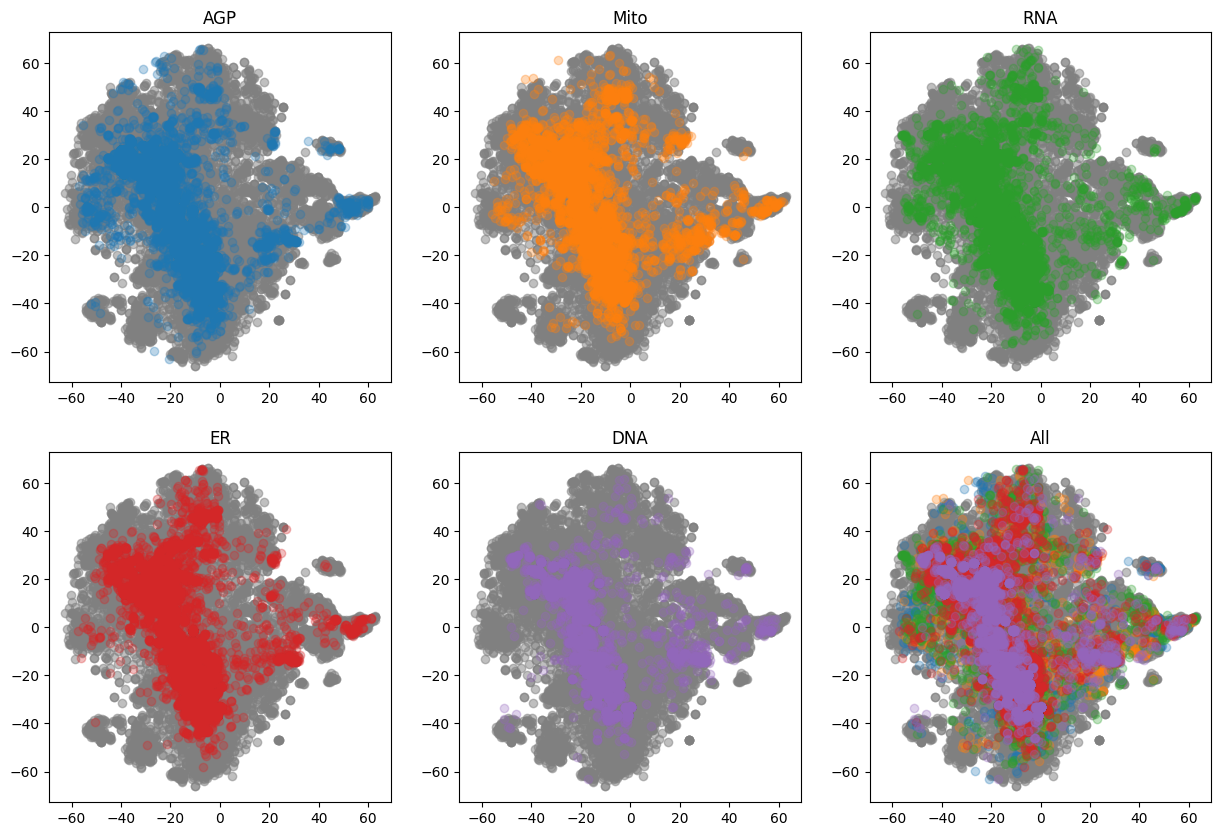

In [32]:
# openTSNE
chnls = ["AGP", "Mito", "RNA", "ER", "DNA"]

open_tsne = openTSNE.TSNE()

bt = open_tsne.fit(np.array(baseline_features))

fig, ax = plt.subplots(2,3, figsize=(15,10))

for i, ch in enumerate(chnls):
    t = bt.transform(np.array(channel_features[ch]))
    
    if i == 0:
        ax.flatten()[-1].scatter(bt[:,0], bt[:,1], alpha=0.5, label='Original', color=colors[0])
        ax.flatten()[-1].set_title("All")

    ax.flatten()[i].scatter(bt[:,0], bt[:,1], alpha=0.5, label='Original', color=colors[0])
    ax.flatten()[i].scatter(t[:,0], t[:,1], alpha=0.3, label=ch, color=colors[i + 1])
    ax.flatten()[i].set_title(str(ch))

    ax.flatten()[-1].scatter(t[:,0], t[:,1], alpha=0.3, label=ch, color=colors[i + 1])

# Streamplot

- Used to display 2D vector field
- Parameters:
    - `X`, `Y`: values (for each of the 2 axis) of OpenTSNE embeddings of original features
    - `U`, `V`: substracting x, y coordinates from Original and Channel embeddings. Represent directinal changes from Original to Channel embeddings

In [29]:
def get_streamplot(bt, ct):
    """Create a vector field representation for 2D data. Calculates the difference between two sets of features and then interpolates these vector differences
    onto a regular grid."""

    X, Y = bt[:, 0], bt[:, 1]
    U, V = ct[:, 0] - bt[:, 0], ct[:, 1] - bt[:, 1]

    # Grid over the embedding space
    grid_x, grid_y = np.linspace(min(X), max(X), 100), np.linspace(min(Y), max(Y), 100)
    grid_u, grid_v = np.meshgrid(grid_x, grid_y)

    # Interpolating the vector data onto the grid
    velocity_u = griddata((X, Y), U, (grid_u, grid_v), method='nearest')
    velocity_v = griddata((X, Y), V, (grid_u, grid_v), method='nearest')

    # Handle NaN values if necessary
    velocity_u = np.nan_to_num(velocity_u)
    velocity_v = np.nan_to_num(velocity_v)

    return grid_x, grid_y, velocity_u, velocity_v

open_tsne = openTSNE.TSNE()
bt = open_tsne.fit(np.array(baseline_features))
open_tsne_embeddings = {ch: bt.transform(np.array(channel_features[ch])) for ch in channel_features.keys()}

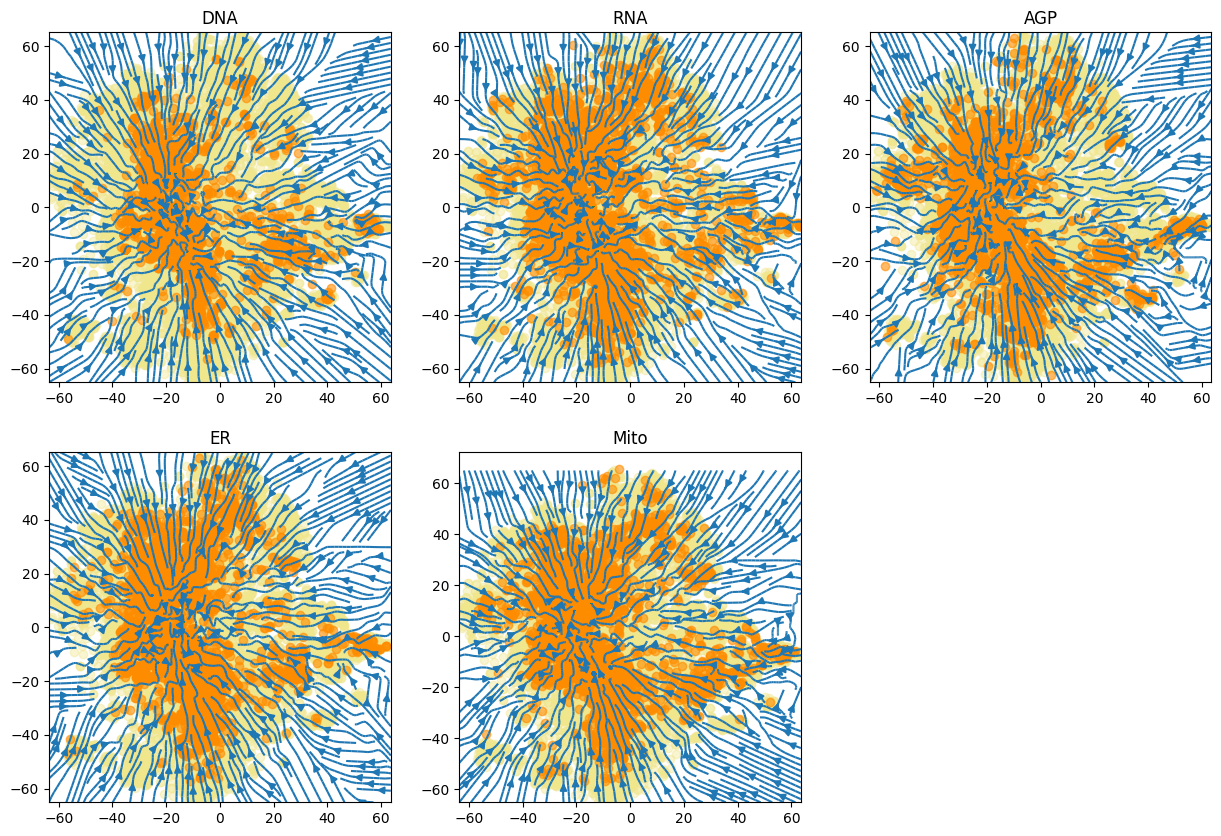

In [3]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax.flat[-1].set_visible(False)

for i, ch in enumerate(open_tsne_embeddings.keys()):
    ct = open_tsne_embeddings[ch]
    grid_x, grid_y, velocity_u, velocity_v = get_streamplot(bt, ct)   
    
    ax.flat[i].streamplot(grid_x, grid_y, velocity_u, velocity_v, density=2)
    ax.flat[i].set_title(str(ch))
    ax.flat[i].scatter(bt[:, 0], bt[:, 1], color='khaki', alpha=0.4)
    ax.flat[i].scatter(ct[:, 0], ct[:, 1], color='darkorange', alpha=0.6)

# Tricountours

- `Triangulation`: organizes random data points into a triangular mesh

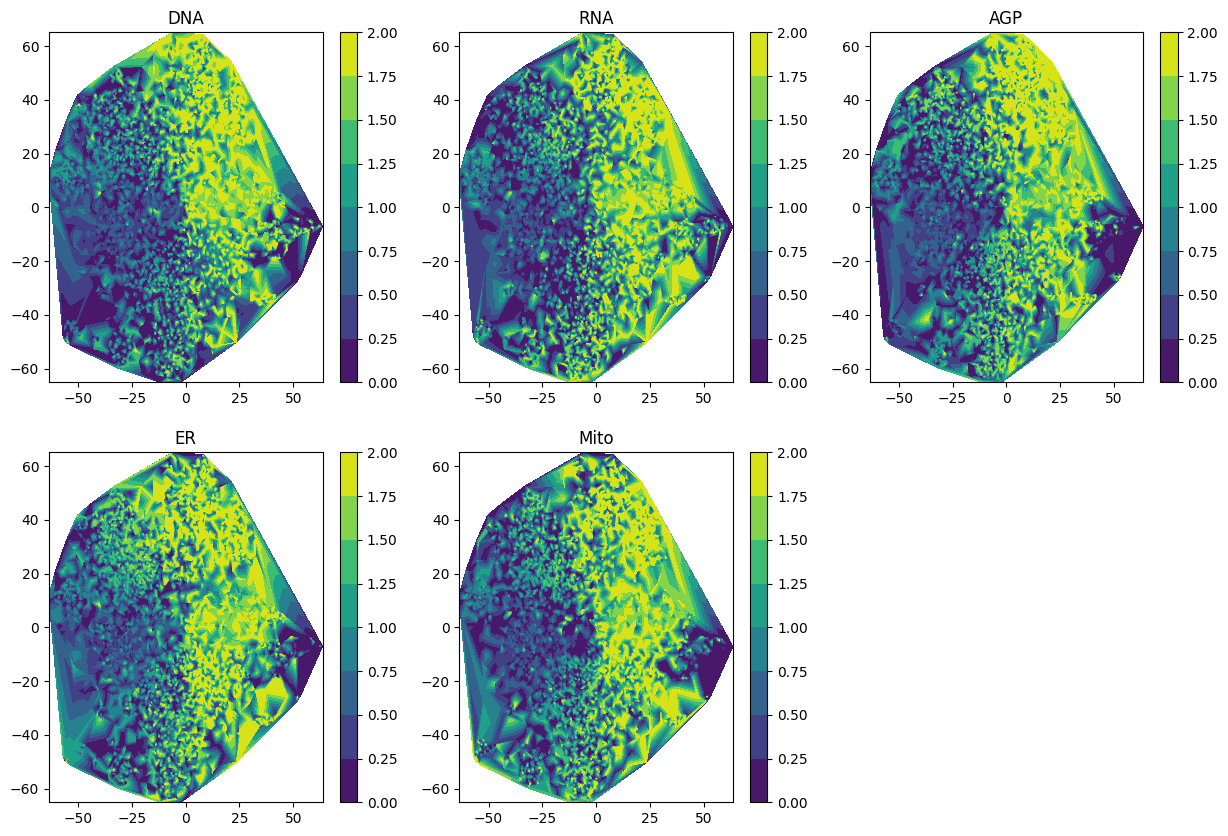

In [11]:
X, Y = bt[:, 0], bt[:, 1]
triang = tri.Triangulation(X, Y)

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax.flat[-1].set_visible(False)

for i, ch in enumerate(open_tsne_embeddings.keys()):
    ct = open_tsne_embeddings[ch]
    Z = cosine_distances(bt, ct)
    cntr = ax.flat[i].tricontourf(triang, Z.diagonal())
    plt.colorbar(cntr, ax=ax.flat[i])
    ax.flat[i].set_title(str(ch))

# KDE - Kernel Density Estimation

- `seaborn.sns.kdeplot`: Plot each set of (7664x2) features/embeddings from OpenTSNE.

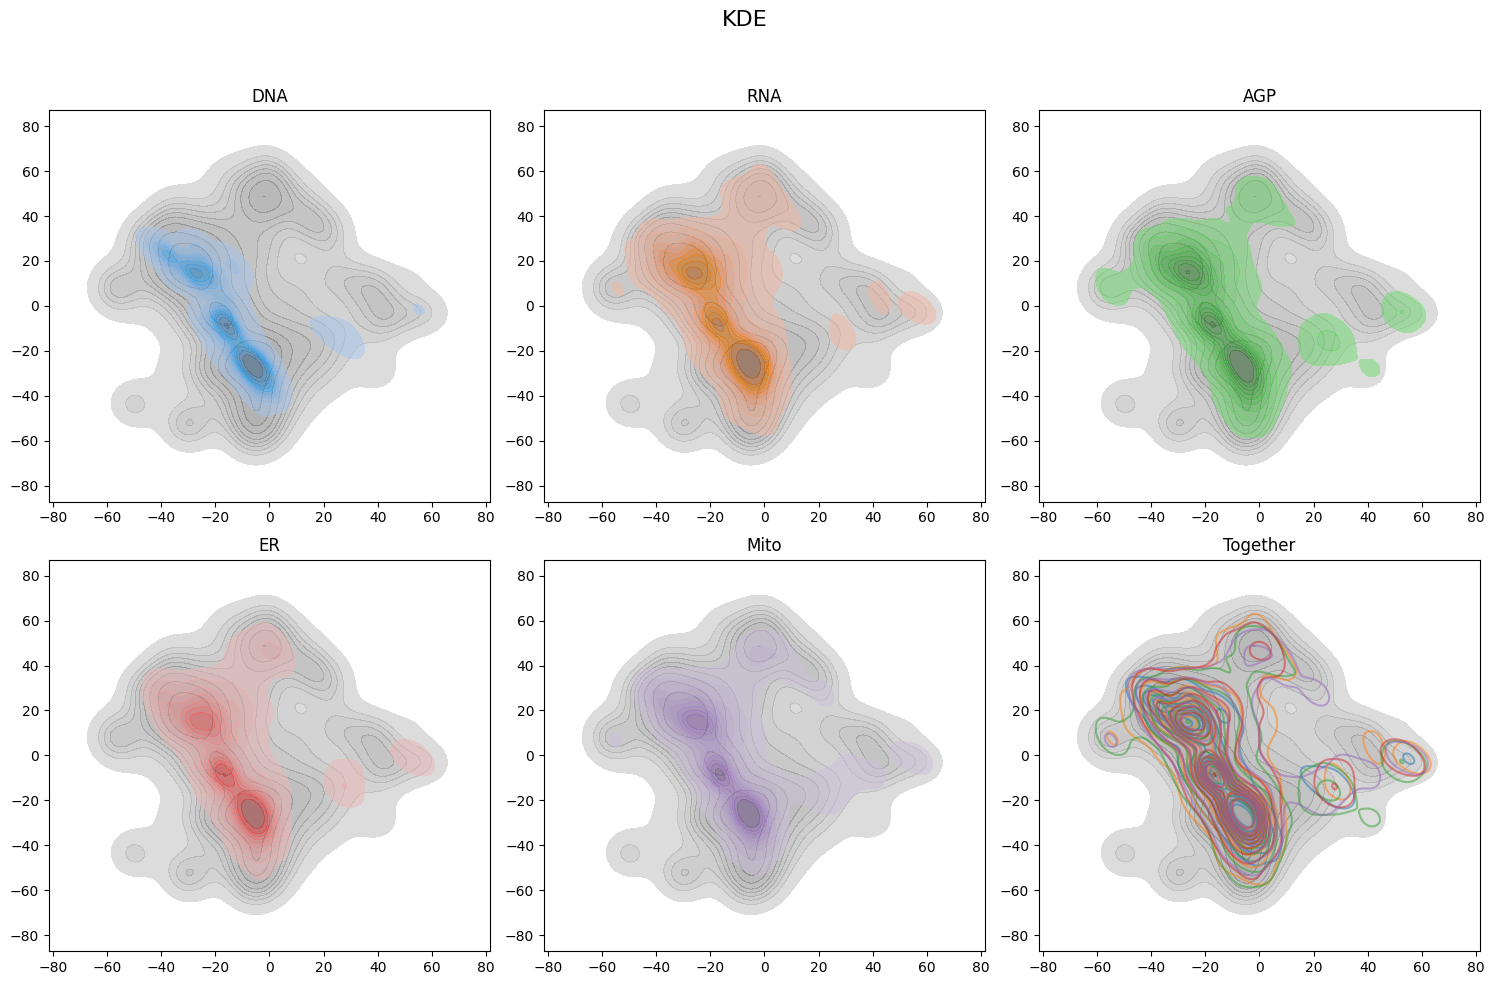

In [30]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

for i, ch in enumerate(open_tsne_embeddings.keys()):
    ct = open_tsne_embeddings[ch]
    
    sns.kdeplot(x=bt[:, 0], y=bt[:, 1], color=colors[0], ax=ax.flat[i], fill=True, alpha=0.5)
    sns.kdeplot(x=ct[:, 0], y=ct[:, 1], color=colors[i + 1], ax=ax.flat[i], fill=True, alpha=0.5)
    ax.flat[i].set_title(str(ch))

    if i == 0:
        sns.kdeplot(x=bt[:, 0], y=bt[:, 1], color=colors[0], ax=ax.flat[-1], fill=True, alpha=0.5)
        ax.flat[-1].set_title("Together")
    sns.kdeplot(x=ct[:, 0], y=ct[:, 1], color=colors[i + 1], ax=ax.flat[-1], fill=False, alpha=0.5)

fig.suptitle("KDE", size=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88)


# Correlation matrix

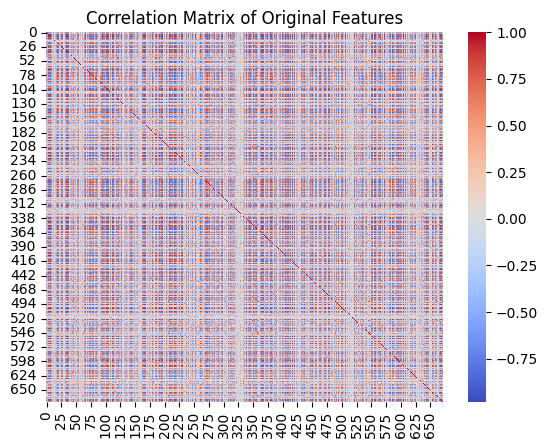

In [27]:
corr_m_features_original = baseline_features.corr()

plt.figure()
sns.heatmap(corr_m_features_original, cmap='coolwarm')
plt.title('Correlation Matrix of Original Features')
plt.show()

# Feature agglomeration

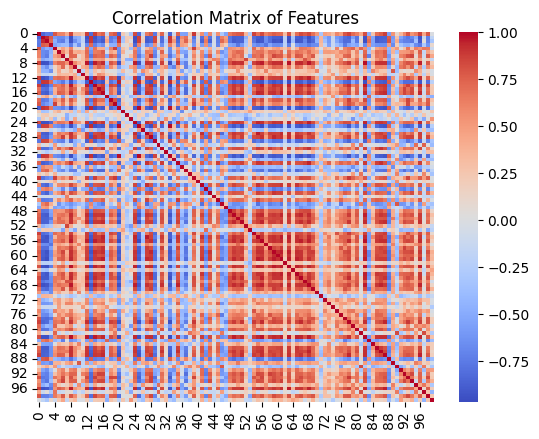

In [23]:
agglo = FeatureAgglomeration(n_clusters=100)
reduced_features = agglo.fit_transform(baseline_features)

reduced_features_df = pd.DataFrame(reduced_features)
corr_m_reduced_features = reduced_features_df.corr()

plt.figure()
sns.heatmap(corr_m_reduced_features, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

# Optimal Leaf Ordering

In [19]:
# Compute the pairwise distances between cells
distance_matrix = pdist(bt, metric='cosine')

# Step 2: Perform the hierarchical clustering
linked = linkage(distance_matrix, method='ward')

# Step 3: Optimal leaf ordering
ordered_linked = optimal_leaf_ordering(linked, distance_matrix)

plt.figure(figsize=(10, 7))
dendrogram(ordered_linked)
plt.title('Hierarchical Clustering with Optimal Leaf Ordering')

![olo](olo.png)

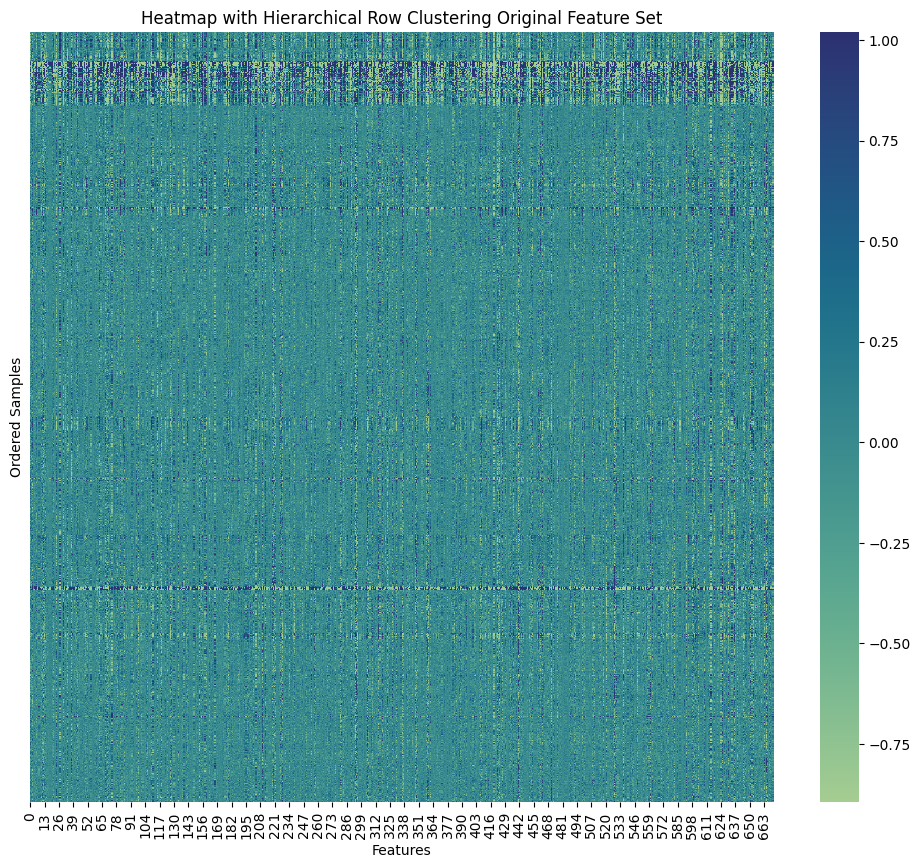

In [19]:
def heatmap_order_features(features):
    # Compute the pairwise distances between rows
    row_distances = pdist(features, metric='cosine')

    # Perform hierarchical clustering
    row_clusters = linkage(row_distances, method='ward')

    # Obtain the order of rows according to the clustering
    row_order = leaves_list(row_clusters)

    # Reorder the DataFrame according to the clustering
    ordered_features = features.iloc[row_order]

    return ordered_features

bh = heatmap_order_features(baseline_features)

plt.figure(figsize=(12, 10))
sns.heatmap(bh, cmap='crest', yticklabels=False, robust=True)
plt.title('Heatmap with Hierarchical Row Clustering - Original Features')
plt.xlabel('Features')
plt.ylabel('Ordered Samples')
plt.show()

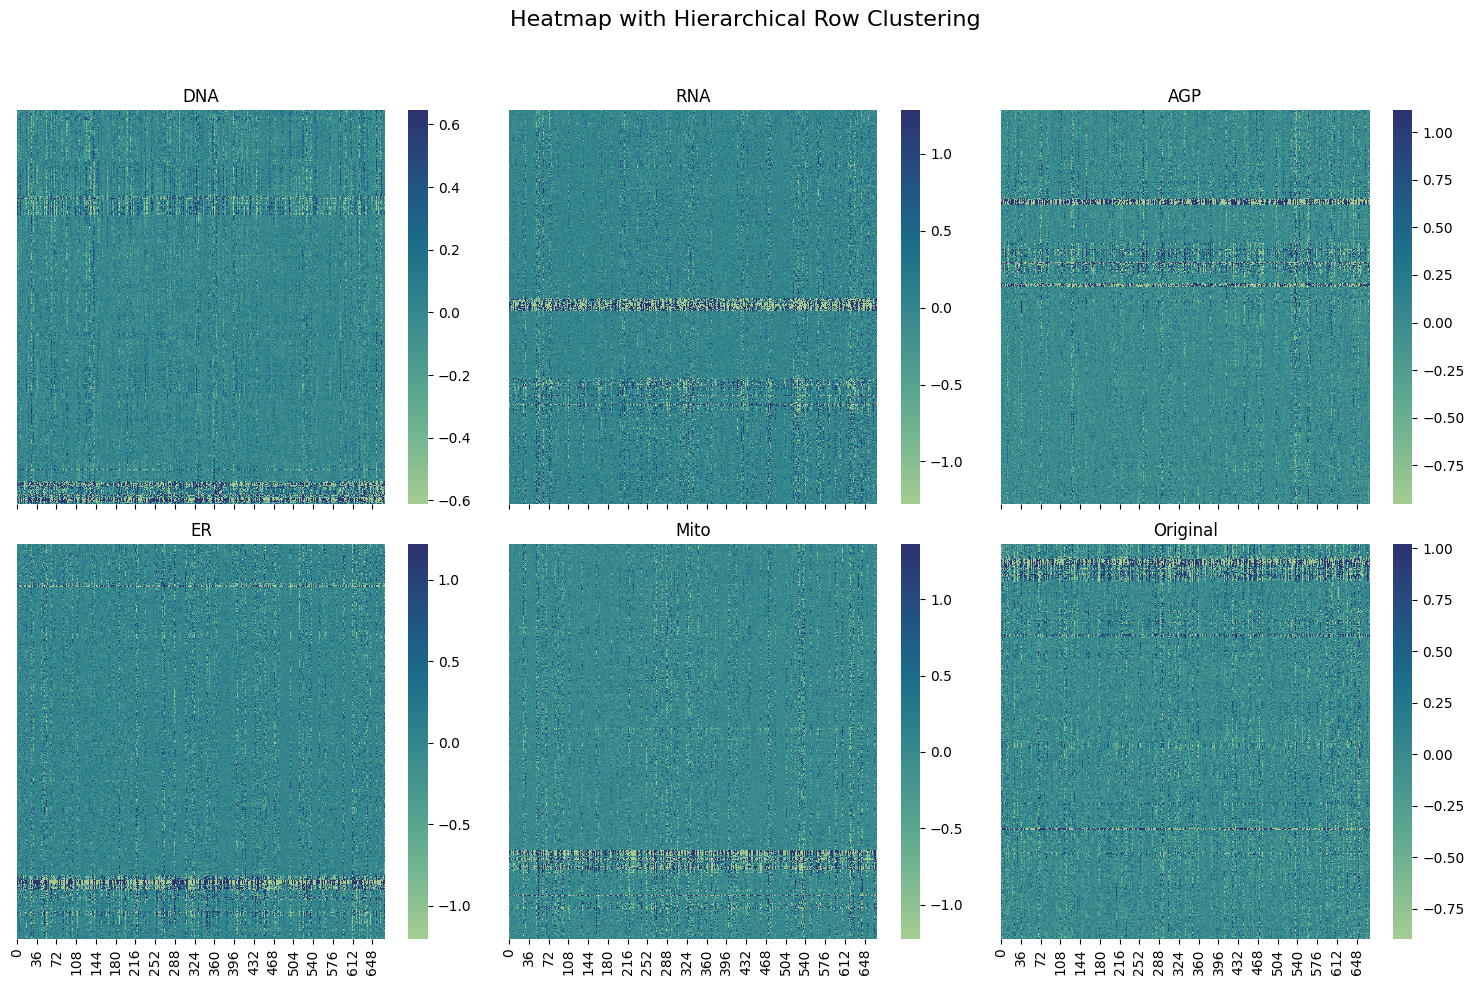

In [20]:
fig, ax = plt.subplots(2,3, figsize=(15,10), sharex=True)

for i, ch in enumerate(channel_features.keys()):
    
    ch_hm = heatmap_order_features(channel_features[ch])
    sns.heatmap(ch_hm, cmap='crest', yticklabels=False, robust=True, ax=ax.flat[i])    
    ax.flat[i].set_title(str(ch))

ax.flat[-1].set_title("Original")
sns.heatmap(bh, cmap='crest', yticklabels=False, robust=True, ax=ax.flat[-1])    

fig.suptitle("Heatmap with Hierarchical Row Clustering", size=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

# Mean differences between sets of features

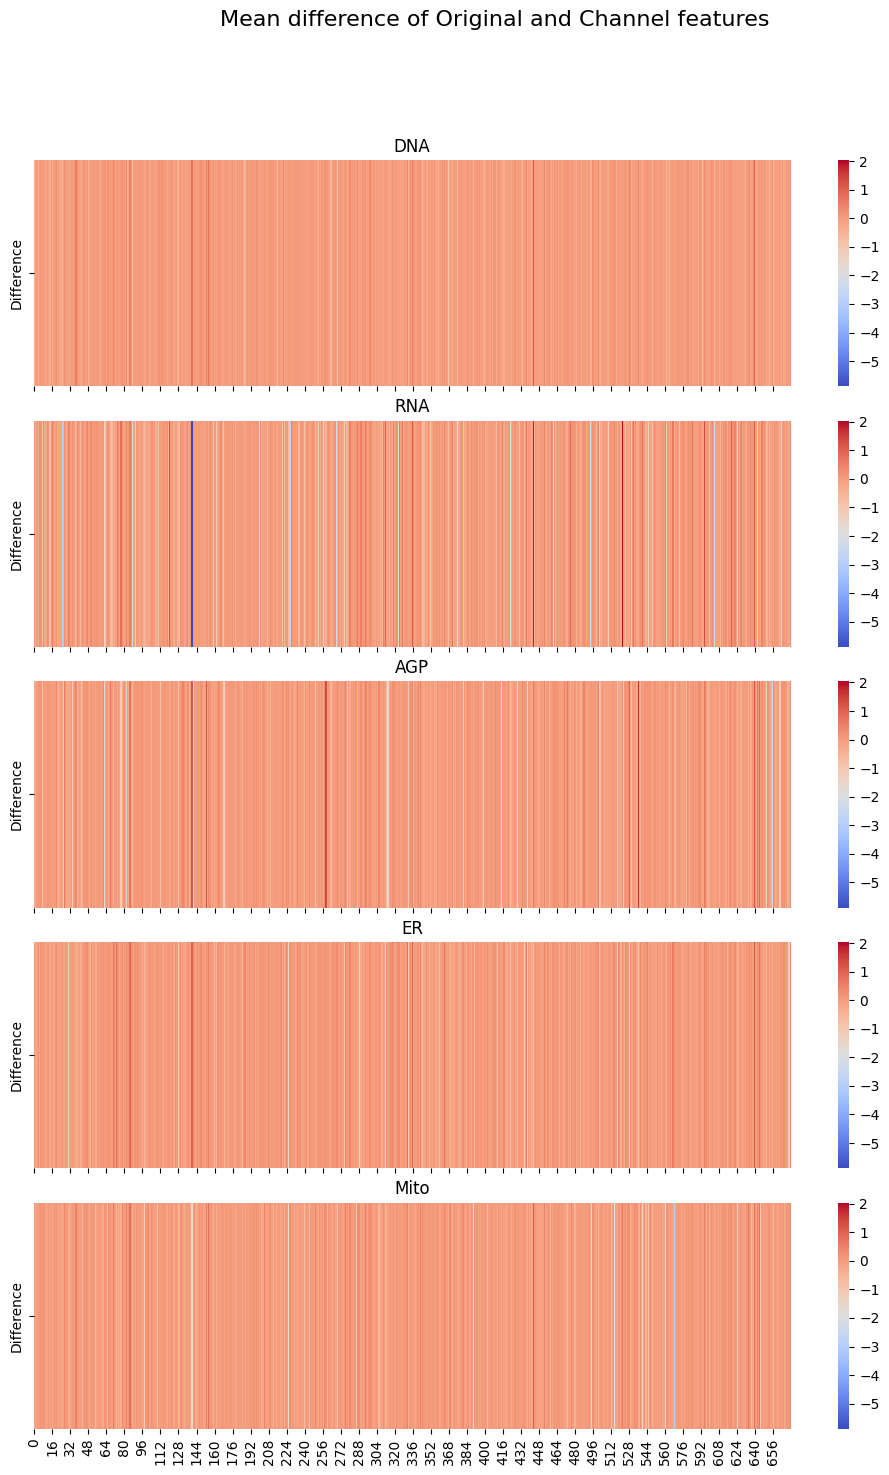

In [16]:
global_min = float('inf')
global_max = float('-inf')

for ch in channel_features.keys():
    mean_diff = (baseline_features - channel_features[ch]).mean(axis=0)
    global_min = min(global_min, mean_diff.min())
    global_max = max(global_max, mean_diff.max())

fig, ax = plt.subplots(5,1, figsize=(10,15), sharex=True, sharey=True)

for i, ch in enumerate(channel_features.keys()):

    mean_diff = pd.DataFrame((baseline_features - channel_features[ch]).mean(axis=0), columns=['Difference']).transpose()
    sns.heatmap(mean_diff, cmap='coolwarm', ax=ax[i], vmin=global_min, vmax=global_max)
    ax.flat[i].set_title(str(ch))

fig.suptitle("Mean difference of Original and Channel features", size=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

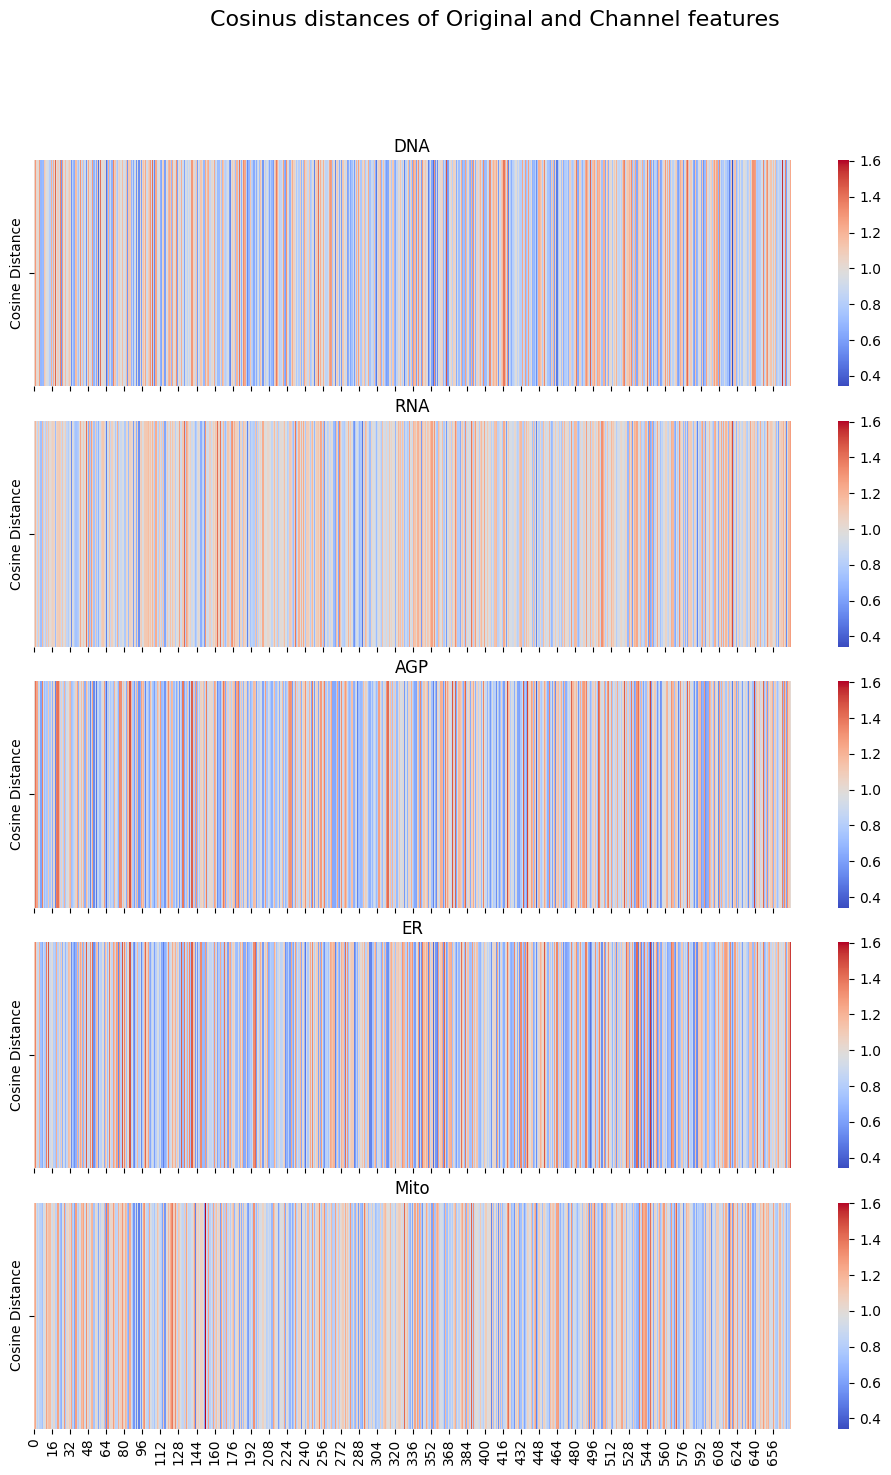

In [15]:
global_min = float('inf')
global_max = float('-inf')

for ch in channel_features.keys():
    cos_distances = [cosine(baseline_features.iloc[:, i], channel_features[ch].iloc[:, i]) for i in range(baseline_features.shape[1])]
    global_min = min(global_min, min(cos_distances))
    global_max = max(global_max, max(cos_distances))

fig, ax = plt.subplots(5,1, figsize=(10,15), sharex=True, sharey=True)

for i, ch in enumerate(channel_features.keys()):
    cos_distances = pd.DataFrame(np.array([cosine(baseline_features.iloc[:, i], channel_features[ch].iloc[:, i]) for i in range(baseline_features.shape[1])]), columns=['Cosine Distance'])
    sns.heatmap(cos_distances.T, cmap='coolwarm', ax=ax[i], vmin=global_min, vmax=global_max)
    ax.flat[i].set_title(str(ch))

fig.suptitle("Cosinus distances of Original and Channel features", size=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88)


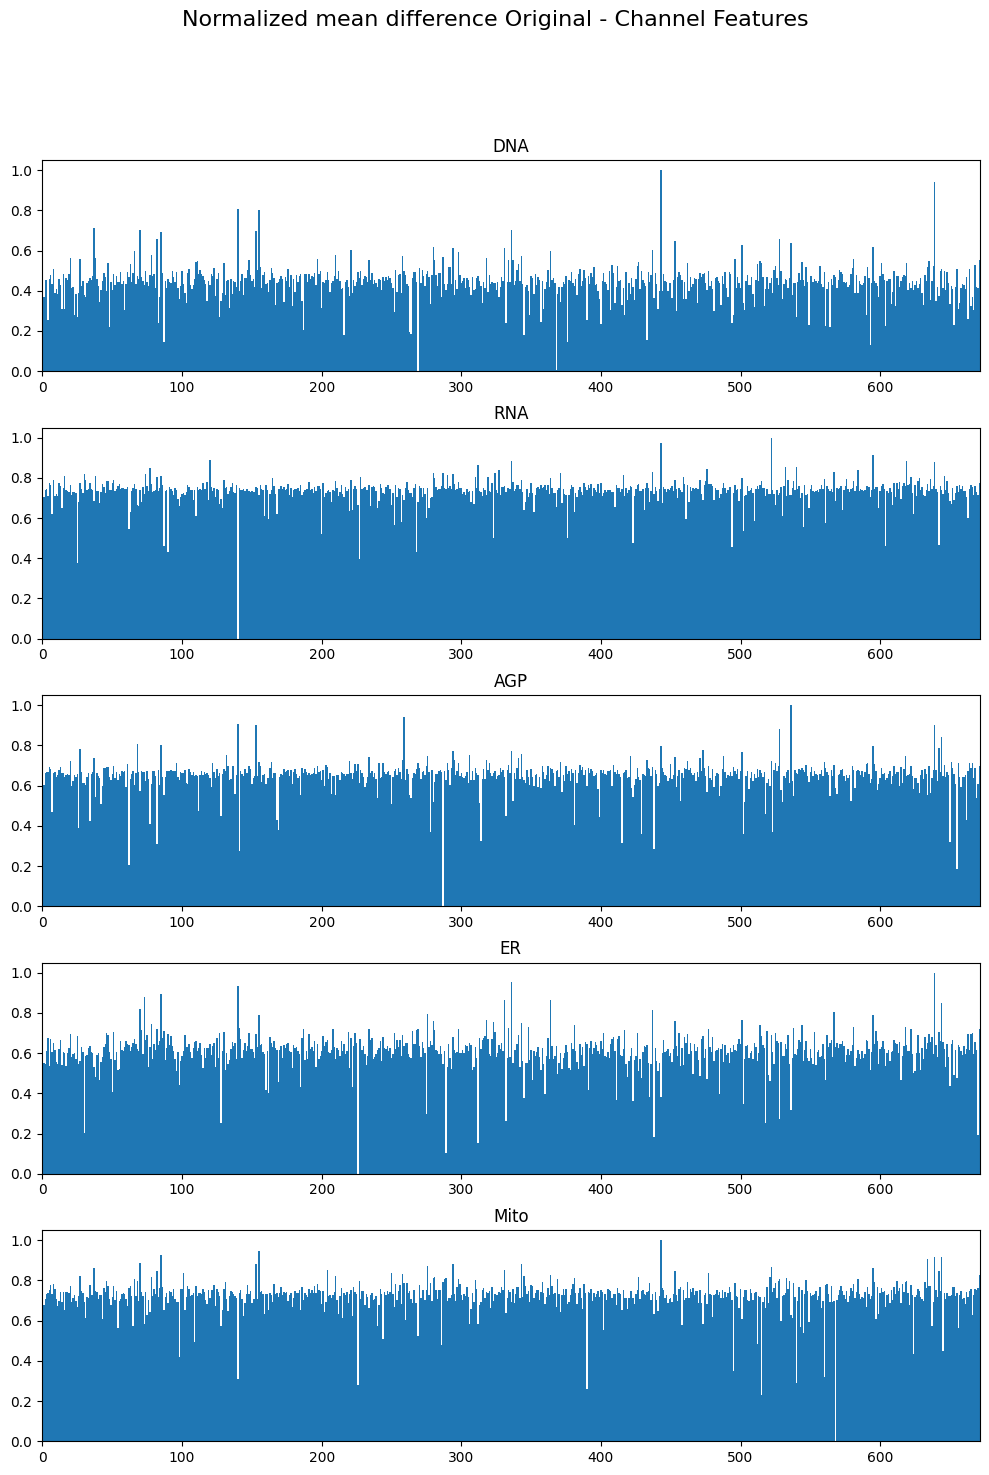

In [22]:
fig, ax = plt.subplots(5,1, figsize=(10,15))

for i, ch in enumerate(channel_features.keys()):
    
    mean_diff = (np.array(baseline_features) - np.array(channel_features[ch])).mean(axis=0)
    mean_diff_norm = ((mean_diff - mean_diff.min()) / (mean_diff.max() - mean_diff.min()))

    ax.flat[i].bar(list(range(672)), mean_diff_norm, width=1)
    ax.flat[i].set_title(str(ch))
    ax.flat[i].margins(x=0)

fig.suptitle("Normalized mean difference Original - Channel Features", size=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

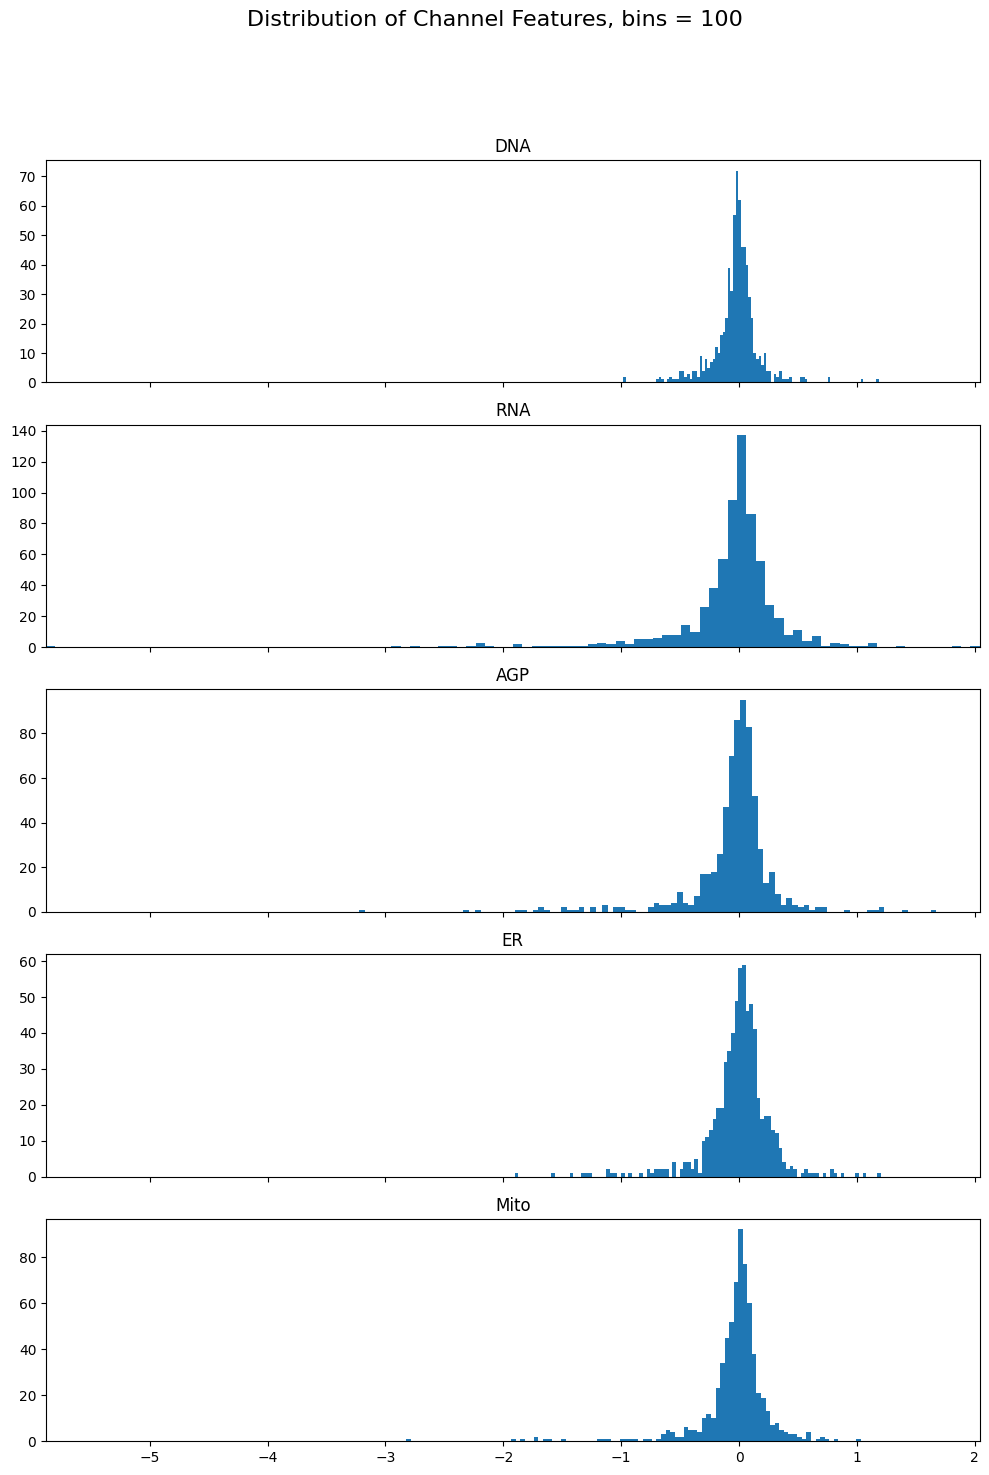

In [21]:
bins = 100

fig, ax = plt.subplots(5,1, figsize=(10,15), sharex=True)

for i, ch in enumerate(channel_features.keys()):

    mean_diff = (np.array(baseline_features) - np.array(channel_features[ch])).mean(axis=0)
    ax.flat[i].hist(mean_diff, bins=bins)
    ax.flat[i].set_title(str(ch))
    ax.flat[i].margins(x=0)

fig.suptitle(f"Distribution of Channel Features, bins = {bins}", size=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

# Feature selection
## Removing features with low variance
Removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.

In [ ]:
thr = 0.5

sel_original = VarianceThreshold(threshold=thr)
reduced_features_original = sel_original.fit_transform(features)

for channel in channels:

    sel_channel = VarianceThreshold(threshold=thr)
    reduced_features = sel_channel.fit_transform(globals()[f"features_{channel}"])

    obtained_original = sel_original.get_support(indices=True)
    obtained_channel = sel_channel.get_support(indices=True)

    print("Obtained original features:", len(obtained_original))
    print(f"Obtained {channel} features:", len(obtained_channel))
    print("Intersection of obtained features:", len(np.intersect1d(obtained_original, obtained_channel)))
    print()


## Univariate feature selection
Works by selecting the best features based on univariate statistical tests.

```f_classif```: Compute the ANOVA F-value for the provided sample.

In [ ]:
k = 100

sel_original = SelectKBest(f_classif, k=k)
k_best_original_ = sel_original.fit_transform(features, np.array(wells_original["Treatment"]))
selected_features_original = sel_original.get_support(indices=True)

for channel in channels:

    sel_channel = SelectKBest(f_classif, k=k)

    k_best_channel_ = sel_channel.fit_transform(globals()[f"features_{channel}"], np.array(globals()[f"wells_{channel}"]["Treatment"]))

    selected_features_channel = sel_channel.get_support(indices=True)

    intersected_features = np.intersect1d(selected_features_original, selected_features_channel)

    print(f"Original {k}-best features:", " ".join(list(map(str, selected_features_original))))
    print(f"{channel} {k}-best features:", " ".join(list(map(str, selected_features_channel))))
    print(f"Intersection ({len(intersected_features)} features):", " ".join(list(map(str, intersected_features))))
    print()